In [4]:
import os
import numpy as np
from math import exp, log
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import random
import gzip
from matplotlib import pyplot
import matplotlib as mpl

%matplotlib inline

data_file_name = {
    'train_image':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_image':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dir_data_file = './data'

train_num = 60000
test_num = 10000
image_dimension = (1, 28, 28)
image_size = 784




In [5]:
def LoadLabel(file_name):
    # file_name의 Binary 파일을 읽어서 numpy.ndarray 를 Return 한다.
    file_path = dir_data_file + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    rtval = data
    print(file_name + " file loaded")
    return rtval

def LoadImage(file_name):
    # file_name의 Binary 파일을 읽어서 numpy.ndarray 를 Return 한다.
    file_path = dir_data_file + "/" + file_name   
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    rtval = data.reshape(-1, image_size)
    print(file_name + " file loaded")
    return rtval

def DictoNumpy():
    ## Dictionary data-type으로 
    dic_data = {}
    print(type(dic_data))
    dic_data['train_image'] =  LoadImage(data_file_name['train_image'])
    dic_data['train_label'] = LoadLabel(data_file_name['train_label'])    
    dic_data['test_image'] = LoadImage(data_file_name['test_image'])
    dic_data['test_label'] = LoadLabel(data_file_name['test_label'])
    
    return dic_data

def ImageDisplay(list_data):
    ## List형의 Pixcel 정보를 받아서 이미지로 보여준다.
    fig = pyplot.figure()
    axis = fig.add_subplot(1,1,1)
    plot_img = axis.imshow(list_data, cmap=mpl.cm.Greys)
    plot_img.set_interpolation('none')
#    ax.xaxis.set_ticks_position('top')
#    ax.yaxis.set_ticks_position('left')
    pyplot.show()

def ascii_show(image):
    for y in image:
        row = ""
        for x  in y:
            row += '{0: <4}'.format(x)
        print (row)
        
        
def MakeNetwork(sizes):
    num_layers = len(sizes)
    input_layer, hidden_layer, output_layer = sizes 
    
    biases = [np.random.randn(y, 1) for y in sizes[1:]]
    weights = [np.random.randn(y, x) 
                for x, y in zip(sizes[:-1], sizes[1:])]
    
    return num_layers, biases, weights

<class 'dict'>
train-images-idx3-ubyte.gz file loaded
train-labels-idx1-ubyte.gz file loaded
t10k-images-idx3-ubyte.gz file loaded
t10k-labels-idx1-ubyte.gz file loaded
<class 'numpy.ndarray'>
5


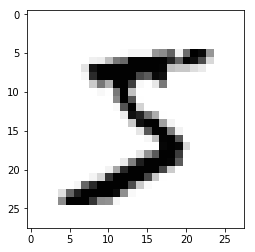

In [6]:
## MNIST Model 설계 
## X = [ 784 x 1 ] , W1 = [ 30 x 784 ], B1 = [ 30 x 1 ]
## A1 = [ 30 x 1 ] , W2 = [ 10 x 30 ], B2 = [ 10 x 1 ]
## A2 = [ 10 x 1 ]


sizes = [784, 30, 10]
num_layers, biases, weights = MakeNetwork(sizes)

dic_data = DictoNumpy()

print (type(dic_data['train_image'][0]))
print (dic_data['train_label'][0])
ImageDisplay (dic_data['train_image'][0].reshape(28,28))


In [12]:
def Sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def SigmoidPrime(x):
    return Sigmoid(x)*(1-Sigmoid(x))

def SoftMax(x):
    exp = np.exp(x-np.max(x))
    return exp / np.sum(exp)

def OneHotLabel(x):
    onehot = np.zeros((x.size, 10))
    for i, row in enumerate(onehot):
        row[x[i]] = 1
    return onehot 

def ForwardPropagation(x, w, b):
    a = np.dot(w, x) + b
    a = a/255
    return a # Sigmoid(a)

def MeanSqrError(y, t):
    return 0.5*np.sum((y-t)**2)

def CrossEntropy ( y, t ):
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))

def PredictOutput(x, weight, biases):
    y1 = ForwardPropagation(x,weights[0],biases[0].reshape(30,))
    a1 = Sigmoid(y1)
    y2 = ForwardPropagation(a1,weights[1],biases[1].reshape(10,))
    return y2

def BackProp (x, layer1, a1, a2, d, weights):
    # DIM (10,1)
    delta_b2 = (a2-d).reshape(10,1)   
    # DIM (10, 30)
    delta_w2 = np.dot(delta_b2,a1.reshape(1,30))  
    # DIM (30, 1 )
    delta_b1 = np.dot(weights[1].reshape(30,10),delta_b2)*SigmoidPrime(layer1.reshape(30,1))
    # DIM (30, 784)
    delta_w1 = np.dot(delta_b1, x.reshape(1,784))
    
    return delta_w1, delta_b1, delta_w2, delta_b2



In [13]:
sizes = [784, 30, 10]
num_layers, biases, weights = MakeNetwork(sizes)
save_init_random_b = biases
save_init_random_w = weights

In [21]:
## 학습 및 테스트 

## Batch 처리
batch_size = 1000
learning_rate = 0.1

num_layers, biases, weights = MakeNetwork(sizes)
input_data = dic_data['train_image']
one_hot_output = OneHotLabel(dic_data['train_label'])

test_data = dic_data['test_image']
one_hot_output_test = OneHotLabel(dic_data['test_label'])

layer1 = 0
layer2 = 0
a1 = 0
a2 = 0

train_err_list = []
test_err_list = []

print ('learning rate : ', learning_rate, )
print ('-----------------------------------------------')

for k in range(int(train_num/batch_size)): # sample selection

    epoch_error = []
    
    for j in range(50): # learning repeat

        dl_w1 = []
        dl_b1 = []
        dl_w2 = []
        dl_b2 = []
        
        prediction_error_batch = []
        
        prediction_error = 0
        

        for i in range(batch_size):
            idx = i+k*batch_size
            layer1 = ForwardPropagation(input_data[idx],weights[0],biases[0].reshape(30,))
            a1 = Sigmoid(layer1)
            layer2 = ForwardPropagation(a1,weights[1],biases[1].reshape(10,))
            a2 = layer2

            d = np.array(one_hot_output[idx])
            error = MeanSqrError(np.array(a2), d)


            d_w1, d_b1, d_w2, d_b2 = BackProp(input_data[idx], layer1, a1, a2, np.array(one_hot_output[idx]), weights)

            dl_w1.append(d_w1)
            dl_b1.append(d_b1)
            dl_w2.append(d_w2)
            dl_b2.append(d_b2)
            
            if np.argmax(a2) == np.argmax(d):
                prediction_error = prediction_error+1

            prediction_error_batch.append(error)
            
        weights[0] = weights[0]-learning_rate*(sum(dl_w1)/batch_size)
        biases[0] = biases[0]-learning_rate*(sum(dl_b1)/batch_size)
        weights[1] = weights[1]-learning_rate*(sum(dl_w2)/batch_size)
        biases[1] = biases[1]-learning_rate*(sum(dl_b2)/batch_size)
    
    test_error = 0
    
    for j in range(test_num):
        idx = j
        a2 = PredictOutput(test_data[idx],weights,biases )
        d = np.array(one_hot_output_test[idx])
        
        if np.argmax(a2) == np.argmax(d):
            test_error = test_error+1
    
    print ('Epoch :', k+1, (k+1)*batch_size, "train-err", prediction_error/batch_size, "test-err", test_error/test_num)
    train_err_list.append(prediction_error/batch_size)
    test_err_list.append(test_error/test_num)
    

learning rate :  0.1
-----------------------------------------------
Epoch : 1 1000 train-err 0.324 test-err 0.2565
Epoch : 2 2000 train-err 0.549 test-err 0.4354
Epoch : 3 3000 train-err 0.708 test-err 0.6123
Epoch : 4 4000 train-err 0.795 test-err 0.6881
Epoch : 5 5000 train-err 0.827 test-err 0.7443
Epoch : 6 6000 train-err 0.844 test-err 0.7756
Epoch : 7 7000 train-err 0.88 test-err 0.807
Epoch : 8 8000 train-err 0.88 test-err 0.8243
Epoch : 9 9000 train-err 0.837 test-err 0.8149
Epoch : 10 10000 train-err 0.906 test-err 0.8184
Epoch : 11 11000 train-err 0.906 test-err 0.8245
Epoch : 12 12000 train-err 0.886 test-err 0.8258
Epoch : 13 13000 train-err 0.888 test-err 0.832
Epoch : 14 14000 train-err 0.887 test-err 0.8265
Epoch : 15 15000 train-err 0.86 test-err 0.8489
Epoch : 16 16000 train-err 0.89 test-err 0.8378
Epoch : 17 17000 train-err 0.872 test-err 0.8553
Epoch : 18 18000 train-err 0.878 test-err 0.8398
Epoch : 19 19000 train-err 0.931 test-err 0.8402
Epoch : 20 20000 train-e

In [23]:
print (save_init_random_b[1])
print (biases[1])

[[ 1.88055822]
 [ 0.30497074]
 [-0.17961919]
 [-1.33175608]
 [-1.31084186]
 [-1.23496436]
 [ 0.51034618]
 [-0.96724618]
 [-0.20493018]
 [-0.02348805]]
[[ 3.04380307]
 [ 7.60867869]
 [ 3.14219975]
 [ 2.96981264]
 [ 2.05106307]
 [ 1.15310446]
 [ 0.78291246]
 [ 5.12515177]
 [ 1.15337218]
 [ 1.6915618 ]]


In [18]:
print (save_init_random_b[1])

[[ 1.88055822]
 [ 0.30497074]
 [-0.17961919]
 [-1.33175608]
 [-1.31084186]
 [-1.23496436]
 [ 0.51034618]
 [-0.96724618]
 [-0.20493018]
 [-0.02348805]]


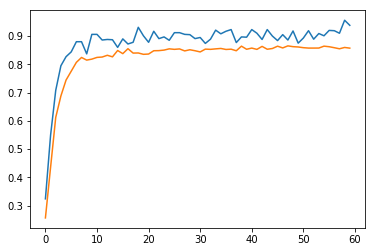

In [24]:
plt.figure()
plt.plot(train_err_list)
plt.plot(test_err_list)